In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import numpy as np
from einops import rearrange, repeat
from torch import einsum

In [2]:
class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

torch.Size([5, 9, 94, 32, 64]) dots

In [3]:
dots = torch.randn(5, 9, 94, 32, 64)

In [5]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    return chunk_grid

In [6]:
ChunkGrid(3008, 32)

tensor([[ 0,  0,  0,  ..., 93, 93, 93],
        [ 1,  1,  1,  ..., 92, 92, 92],
        [ 2,  2,  2,  ..., 91, 91, 91],
        ...,
        [91, 91, 91,  ...,  2,  2,  2],
        [92, 92, 92,  ...,  1,  1,  1],
        [93, 93, 93,  ...,  0,  0,  0]])

In [7]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    #chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
    return chunk_grid

In [8]:
chunkgrid = ChunkGrid(4800, 48)
pareto = torch.distributions.pareto.Pareto(torch.tensor(3.0), torch.tensor(2.0)).sample(chunkgrid.shape)
chunkgrid = chunkgrid - pareto

column = 0
print(chunkgrid[column].topk(384, largest=False).indices.max())
chunkgrid[column].topk(384, largest=False).indices.sort(-1).values

tensor(4792)


tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
          60,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,
          72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
          84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,
          96,   97,   98,   99,  100,  101,  102,  103,  104,  105,  106,  107,
         108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
         120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
         144,  145,  146,  147,  148,  1

In [9]:
chunkgrid.shape

torch.Size([100, 4800])

In [10]:
from matplotlib import pyplot as plt

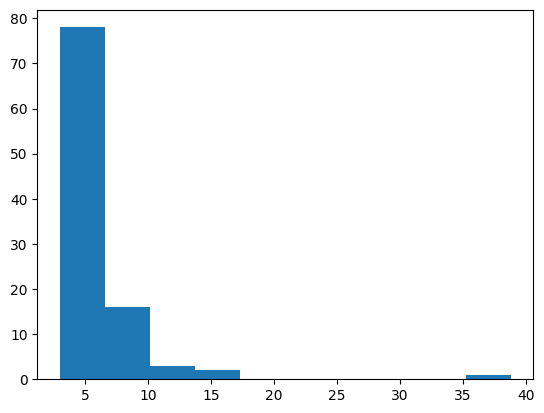

In [12]:
dist = torch.distributions.pareto.Pareto(3, 2).sample(torch.tensor([100]))
plt.hist(dist)
plt.show()

In [13]:
print(chunkgrid[0].topk(40, largest=False).indices.max())
chunkgrid[0].topk(40, largest=False).indices


tensor(4792)


tensor([ 160,  358,  318, 4792,  246, 3209,  158, 2323,  467, 2915, 1295,    0,
          68, 1215, 2154,  945,   54,   11,  946,   47,  275,   67,  950,  137,
          60,   84,  102,   72,  157,  114, 1095,  112,  579,  199,  231,  431,
         363,  444,  756,  607])

In [48]:
torch.ones(8, 8).triu(1).bool()

tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False]])

In [106]:
def exists(val):
    return val is not None

class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

class MyopicAttention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.0,
        max_keep_keys=50,
        chunk_window=3,
        bias=True,
        return_attention=False,
        causal=False,
    ):
        super().__init__()
        self.n_feats = n_feats
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.bias = bias
        self.return_attention = return_attention

        self.causal = causal

        self.scale = head_dim ** -0.5

        self.max_keep_keys = max_keep_keys
        self.W = chunk_window

        self.positional_bias = DynamicPositionBias(
            dim = n_feats,
            heads = n_heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

    def pad_to_window_size(self, x, window_size, axis=3, mask=None):
        """
        Pad the input on two sides to be divisible by `window_size`
        """
        QKV, batch_size, heads, sequence_length, hidden_size = x.shape
        padding_length = (window_size - sequence_length % window_size) % window_size
        padding = torch.zeros(QKV, batch_size, heads, padding_length, hidden_size,
            device=x.device,
            dtype=x.dtype,
        )
        mask = F.pad(mask, (0, padding_length), value=True) 
        return torch.cat([x, padding], axis=axis), padding_length, mask

    def unpad(self, x, padding_length):
        """
        Undo padding.
        """
        if padding_length > 0:
            return x[:, :-padding_length]
        return x

    def ChunkGrid(self, Total_Size, Block_Size):
        Psize = Total_Size // Block_Size
        chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
        #chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1)) # don't normalize cus it'll stretch the distribution by sequence length
        return chunk_grid    

    def causal_windowed_mask(self, window_number, window_size, device):
        return torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)

    def forward(self, x, mask, return_attention=False):
        assert mask is not None, 'pls wear a mask'
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim

        tokeep = min(self.max_keep_keys, N) if self.max_keep_keys != -1 else N # number of keys to keep
        W = min(self.W, N) if self.W != -1 else N # window size

        qkv = rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=H, d=D) # qkv projection

        qkv, pad_n, mask = self.pad_to_window_size(qkv, W, axis=3, mask=mask) # add padding so it's divisible by W
        q, kv = qkv[0], qkv[1:] # separate q and kv, we keep kv together for now as we apply the same operations to both
        
        q = rearrange(q, "b h (n w) d -> b h n w d", w=W)# split q into windows/chunks of size W
      
        q_mask = repeat(rearrange(mask, "b (n w) -> b n w", w=W), "b n w -> b h n w", h=H) # do the same for the mask
            
        kv = repeat(kv, "kv b h n d -> kv b h nw n d", nw=q.shape[2]) # duplicate k and v for total number of windows
        #print(q.shape, kv.shape)
        KV, B, H, NW, N, D = kv.shape

        chunkgrid = self.ChunkGrid(Total_Size=N, Block_Size=W).to(q.device)
        chunkgrid = repeat(chunkgrid, "w n -> b h w n", b=B, h=H).contiguous()

        SCALE = torch.tensor(3.0, device=q.device, dtype=q.dtype)
        ALPHA = torch.tensor(2.0, device=q.device, dtype=q.dtype)
        pareto_dist = torch.distributions.pareto.Pareto(SCALE, ALPHA).sample(chunkgrid.shape).to(q.device)
        chunkgrid = chunkgrid - pareto_dist

        chunkgrid = repeat(chunkgrid, "b h w n -> kv b h w n", kv=2)

        cmask = repeat(mask, 'b n -> kv b h nw n', kv=2, h=H, nw=NW)

        if self.causal:
            causal_mask = self.causal_windowed_mask(window_number=NW, window_size=W, device=q.device)
            cmask = cmask & causal_mask
        
        chunkgrid = chunkgrid.masked_fill(cmask, torch.finfo(q.dtype).max) # max cus we topk in reverse order 

        keep_indices = chunkgrid.topk(k=tokeep, dim=-1, sorted=False, largest=False).indices.sort(dim=-1).values
        KV, B, H, NW, N, D = kv.shape 
        kv = kv.gather(-2, repeat(keep_indices, "kv b h w n -> kv b h w n d", d=D))

        kv_mask = repeat(mask, "b n -> b h nw n", h=H, nw=NW)
        if self.causal:
            kv_mask = kv_mask & causal_mask 
        kv_mask = kv_mask.gather(-1, keep_indices[0])

        k, v = kv
        # nw (number of windows) = p (in the einsum below)
        dots = einsum("b h n p d, b h n z d -> b h n p z ", q, k) * self.scale # Z is number of chunks in Q, N is max sequence length after dropping

        ## positional stuff
        pos_bias = self.positional_bias(N, device=dots.device, dtype=dots.dtype)
        pos_bias = repeat(pos_bias, 'h i j -> b h i j', b = B)
        pos_bias = rearrange(pos_bias, 'b h (n w) j -> b h n w j', w = W)

        pos_bias = pos_bias.gather(-1, repeat(keep_indices, "kv b h nw n -> kv b h nw w n", w=W)[0])
        
        dots = dots + pos_bias

  
        mask_val = -torch.finfo(dots.dtype).max
        qk_mask = rearrange(q_mask, "b h n w -> b h n w ()") * rearrange(kv_mask, "b h w n -> b h w () n")
        dots.masked_fill_(qk_mask, mask_val)

        attn = dots.softmax(dim=-1)
  
        out = einsum("b h n w z, b h n z d -> b h n w d", attn, v)
        out = rearrange(out, "b h n w d -> b (n w) (h d)")
        out = self.unpad(out, pad_n)
        out = self.out_proj(out)
        return out if not return_attention else (out, attn)

        

In [111]:
attention = MyopicAttention(n_feats=216, head_dim=24, n_heads=12, max_keep_keys=250, chunk_window=48, causal=True)

x = torch.randn(10, 1000, 216)
mask = torch.zeros(10, 1000).bool()

attn = attention(x, mask)

In [16]:
x = torch.randn(10, 1000, 216)
mask = torch.zeros(10, 1000).bool()

In [ ]:
### OLD CHUNKGRID SHIT
def ChunkGrid(self, Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
    return chunk_grid    

chunkgrid = repeat(chunkgrid, "w n -> b h w n", b=B, h=H).contiguous()
MEAN = torch.tensor(0, device=q.device, dtype=q.dtype)
STD = torch.tensor(0.125, device=q.device, dtype=q.dtype)
uniform_dist = torch.distributions.normal.Normal(MEAN, STD).sample(chunkgrid.shape).to(q.device)
chunkgrid += uniform_dist
chunkgrid = repeat(chunkgrid, "b h w n -> kv b h w n", kv=2)

In [72]:
def causal_windowed_mask(window_number, window_size, device):
    mask = torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)
    return mask

In [74]:
causal_windowed_mask(3, 4, device='cpu').shape

torch.Size([3, 12])

In [ ]:
a.indices.sort().values[0, 0, 0, 0]

In [ ]:
torch.tensor(2).unsqueeze(-1).repeat(2).expand(2, 2)

In [ ]:
torch.randn()

In [ ]:
km.shape

In [ ]:
km[0, 0, :, 0, :100].sum(-1)

In [ ]:
km.shape

In [ ]:
(torch.arange(0, 3008).repeat(3008,1) - torch.arange(0, 3008).repeat(3008,1).T).reshape(32, -1, 3008).shape

- duplicated across KV
- each batch, head and Window have a different view of the keys
- 94 is the number of windows i.e 94*32(win size) = 3008 (sequence length)

In [ ]:
kv.shape

In [ ]:
kv[km].reshape(2, 5, 8, 3, -1, 24).shape

In [ ]:
repeat(cg, "W N -> KV B H W N", B=5, H=8, KV=2).shape

In [ ]:
kv.s

In [ ]:
def ChunkGrid(N_BLOCKS, BLOCK_SIZE):
    chunk_grid = (torch.arange(0, N_BLOCKS).repeat(BLOCK_SIZE,1) - torch.arange(0, BLOCK_SIZE).repeat(N_BLOCKS,1).T).repeat_interleave(BLOCK_SIZE, dim=1).abs()
    chunk_grid = chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1)
    return chunk_grid

In [ ]:
cg = ChunkGrid(41, 3)
uniform_dist = torch.distributions.uniform.Uniform(0, 1).sample(cg.shape)
cg += uniform_dist
keep_indices = cg.topk(9, dim=-1).indices
keep_mask = torch.zeros_like(cg).scatter_(1, keep_indices, 1).bool()

In [ ]:
cg.shape

In [ ]:
keep_mask